Chapter Outline:
    1. Recap
    2. Chapter Goals
    3. GMM intuition
    4. ...
    5. Conclusions

## 1. Recap

In the last chapter we went through some foundational concepts. 

We discussed stationarity, why it is important, and its rules. We were able to understand the concept by thoroughly examining the most common ways that financial time series violate the requirements. 

We illustrated how financial time series have trends _(means vary with time)_, changing volatility _(variance changes with time)_, clustering volatility _(autocorrelation between t and t+i)_.

Using statistical techniques we demonstrated that asset returns from different time periods and scales appear to come from different distributions.

We concluded that for our purposes of predicting future return distributions, techniques that cannot accomodate the time varying properties of financial asset returns are a danger to our trading acocunts.

## 2. Chapter Goals

In this chapter we will see how Gaussian Mixture Models (gmm) can help overcome some of the time series prediction issues we identified in chapter 1.

1. Understand how GMM's can approximate nonstationary distributions
2. Use `sklearn` to choose the optimal number of components
3. Use `seaborn, plotnine`, and `matplotlib` for visual analysis


## 3. Gaussian Mixture Models (GMM) Intuition


Our biggest pain point results from the idea that asset returns are comprised of multiple distributions. Time varying means, and volatilities can be considered as coming from different distributions, regimes, or states _(moving forward I will use those terms interchangeably)_. Each regime has its own parameters. 

For example consider two regimes with the following characteristics.
    
    1. Stable, low volatility
    2. Unstable, high(er) volatility

We can make an assumption that every data point from our return series has come from either the _stable_ or _unstable_ regime. If we can classify each data point correctly then we can use the current regime's parameters as the input to our prediction for the next period. _As we know, the best estimate for an unpredictable future state is the current state._

That sounds good however we still have some challenges. 

1. We do not know the parameters, ($\mu, \sigma$), for the two regimes. 
2. We do not know which datapoint came from which regime.

On first pass this problem seems intractable. 

Fortunately for us, some smart people devised a solution. 

> __Expectation-maximization algorithm (EM, E-M, em, etc.)__

Most introductory texts on this subject explain the topic using heavy maths first, somewhat obscuring the concept and leaving one feeling like its _magic_ and moving on. I hope to avoid that outcome in this brief intro and make it more intuitive. 

#### Why do we need EM, why bother to understand it?

The EM algorithm and derivations thereof underpin many unsupervised learning methods including mixture modeling. It is useful in many real world applications where:

    - Data is corrupted.
    - Data is missing.
    - We do not know the parameters of data generating process (aka model, distribution).
    - We do not know which data generating process generated which data point.
    
Let's continue with our example of an asset return series being generated by a combination of 2 Gaussian distributions. To start we let's say we have `252 days` of return data do not know the prior probability that a random return value came from the `stable` regime. Fortunately for us we can start with terrible guesses __that we know are likely incorrect__.

Notes to self:

we have 2 regimes and a time series of returns. to start the algo we guess parameters of both regimes. say stable regime has `2.5%` returns and `9%` volatility, the volatile regime has `-1.0%` returns and `25%` volatility. 

We assume those incorrect guesses are correct and proceed to assign probabilities aka weights aka responsiblities to each data point. So for example assume the first data point we have is a return of `1.25%`. We must compute the probability that a Gaussian distribution with mean `2.5%` and std of `9%` generated that return. Because we only have two regimes the probability that the `volatile` regime generated the datapoint is $1 - P_stable$. We do that for all the returns on the first pass, again reusing those initial incorrect guesses about the means and volatilties.

Now we use those assignments to reestimate the means and volatilities of the regimes. 

Now we use that information (mle) to compute the prior probability that the `stable` regime generated the return data

regimes have unknown biases theta_a, theta_b, or stable vs volatile, and their probability of generating a particular return/data point. In the coin flipping example this bias is represented as a binomial distro with bernoulli trials b/c there are 2 discrete outcomes. In the continuous case, this bias must be represented as a continuous distribution (gaussian, or normal distribution). 

translate coin flipping example to continuous case. coin flip tracks two vectors, `xs`, and `zs` where $x_i$ in the set ${0, 1,...,N}$ in coin flip is number of times heads was observed in a bernoulli trial, in our application it is simply the observed return value. N is the total number of experiments/observations. zs are the label of which coin, regime was generating the data.

The mle then for coin flip is computing proportion of heads for coin a, and the same for coin b. for our case it would be computing probability that stable regime ~  $N(\mu, \sigma^2)$ would generate the observed return, and the same for the volatile regime. 

In coin example if log-likelihood is obtaining vector of observed head counts/observations `x` and coin types/regimes `y` then proportion of heads formulas for coins a or b solve for the parameters theta. 

In [1]:
%load_ext watermark
%watermark

from IPython.display import display

# import standard libs
from pathlib import PurePath, Path
import sys
import time

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)

# import python scientific stack

import pandas as pd
#pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats

# import visual tools

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# set globals
"""['_classic_test', 'grayscale', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-white', 'fivethirtyeight', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark', 'seaborn', 'seaborn-pastel', 'dark_background', 'seaborn-notebook', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'seaborn-talk']"""
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = 9,7

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,pyarrow

2017-11-30T18:01:53-07:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


/home/bcr/anaconda3/envs/bayesian/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pandas 0.21.0
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 1.0.0
matplotlib 2.1.0
seaborn 0.8.1
plotnine 0.3.0+9.g6519baa
pyarrow 0.7.1


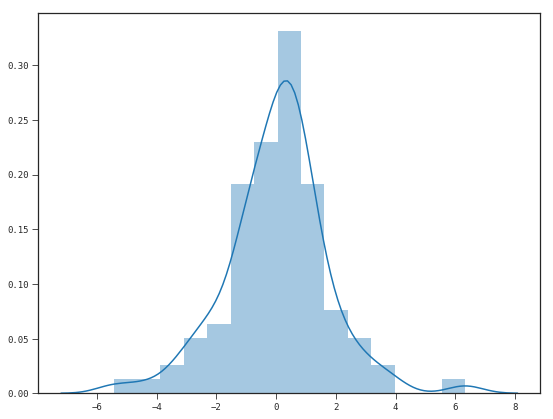

In [4]:
np.random.seed(777)

N = 100

fake_dates = pd.date_range('2011', periods=N)
fake_returns = np.random.laplace(size=N) + np.random.normal(size=N)
returns = pd.Series(fake_returns, index=fake_dates)

sns.distplot(returns)

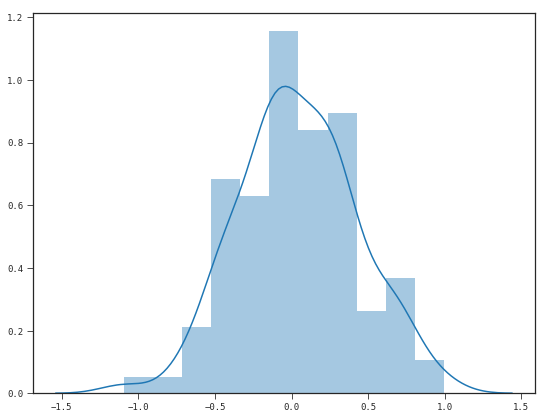

In [86]:
# Let's create some example return data to walk through the process. We will create a synthetic return series composed of two gaussians with different parameters. 
N = 100

true_stable_mu, true_stable_sigma = 0.05, 0.11
true_risky_mu, true_risky_sigma = 0.0125, 0.25

true_prob_stable = 0.6
true_prob_risky = 1 - true_prob_stable

true_mus = [true_stable_mu, true_risky_mu]
true_sigmas = [true_stable_sigma, true_risky_sigma]
true_probs = [true_prob_stable, true_prob_risky]

def mix_data(mus, sigmas, probs, N):
    np.random.seed(777)
    #fake_returns_list = []
    
    #for j, pi in enumerate(probs):
    #    dist_kwds = dict(loc=mus[j], scale=sigmas[j], size=N//len(mus))
    #    #tmp_rets = pi * np.random.laplace(**dist_kwds) + np.random.normal(**dist_kwds)
    #    tmp_rets = pi *  np.random.normal(**dist_kwds)
    #    fake_returns_list.append(tmp_rets)
    
    fake_returns = np.concatenate([np.random.multivariate_normal([mu], np.eye(1)*sigma, int(pi*N))
                    for pi, mu, sigma in zip(probs, mus, sigmas)])

    
    #fake_returns = np.concatenate(fake_returns_list)
    #np.random.shuffle(fake_returns)    
    
    #fake_dates = pd.date_range('2011', periods=N)
    #fake_returns = pd.Series(fake_returns, index=fake_dates)
    
    return fake_returns

mixed = mix_data(true_mus, true_sigmas, true_probs, N=N)
sns.distplot(mixed)

In [87]:
mixed

array([[ -1.05287289e-01],
       [ -2.22900131e-01],
       [  2.83158732e-02],
       [ -1.86595384e-01],
       [  3.50602582e-01],
       [  3.04131974e-01],
       [  3.23971141e-01],
       [ -3.89015914e-01],
       [ -5.31220095e-01],
       [  3.82474743e-01],
       [  2.30692854e-01],
       [  6.78553763e-01],
       [ -2.05167001e-01],
       [ -4.15354270e-01],
       [ -1.59765741e-01],
       [ -1.35357426e-01],
       [ -3.59016578e-01],
       [ -9.57668274e-02],
       [  3.53400610e-01],
       [  1.37904132e-01],
       [ -4.08811974e-01],
       [  2.77358544e-01],
       [  2.01268243e-01],
       [ -1.03020532e-01],
       [  8.14085379e-02],
       [ -4.61692722e-01],
       [  8.72313867e-01],
       [  2.01525562e-01],
       [ -5.40998237e-02],
       [  5.69773097e-02],
       [  3.68659042e-01],
       [  6.93965826e-02],
       [ -9.79321349e-02],
       [  1.55865715e-01],
       [  3.28984071e-01],
       [ -4.58359643e-01],
       [ -4.33909332e-02],
 

In [83]:
np.random.multivariate_normal([0.05], np.eye(1), 10)

array([[-0.41820879],
       [-0.77282485],
       [-0.0153801 ],
       [-0.66336192],
       [ 0.95635089],
       [ 0.81623673],
       [ 0.87605407],
       [-1.27368279],
       [-1.70244452],
       [ 1.05244907]])

In [84]:
np.concatenate([np.random.multivariate_normal([mu], np.eye(1)*sigma, int(pi*N))
                    for pi, mu, sigma in zip(probs, mus, sigmas)])

NameError: name 'probs' is not defined

In [ ]:
# now we make terrible guesses

In [116]:
# terrible guesses at the true prior probability
init_stable_prob = 0.5
init_volatile_prob = 0.5

# guesses at starting mean
init_stable_mean = 0.025
init_volatile_mean = 0.02

# guesses at starting covariance
init_stable_std = 0.05
init_volatile_std = 0.1

#init_cov = np.array([[init_stable_std, 0.],[0., init_volatile_std]])

init_probs = [init_stable_prob, init_volatile_prob]
init_means = [init_stable_mean, init_volatile_mean]
init_sigmas = [init_stable_std, init_volatile_std]

In [117]:
def em_gmm(xs, mus, sigmas, prior_probs, max_iter=150, tol=1e-2):
    
    N = len(xs) # number of data points
    k = len(prior_probs) # number of classes, regimes, distros
    
    ll_old = 0 # init log-likelihood value
    
    # iterate until convergence or max_iter
    for _iter in range(max_iter):
        ll_new = 0
        
        # E-step
        # 
        # compute responsibilities, wts as probability cluster w/ params would generate that point
        
        ws = np.zeros((k, N))
        for j in range(k):
            for i in range(N):
                ws[j, i] = prior_probs[j] * stats.norm(loc=mus[j], scale=sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0) # normalize? weights
        #ws
        
        # M-step
        # 
        # compute updated parameters including probability of class_i, mus, sigs
        
        # update prior probs
        prior_probs = np.zeros(k)
        for j in range(k): # iterate through regimes, classes
            for i in range(N): # iterate through data points
                prior_probs[j] += ws[j, i] # accumulate/sum weights for each regime
        prior_probs /= N # normalize probabilities
        #prior_probs

        # update mus
        mus = np.zeros(k)
        for j in range(k):
            for i in range(N):
                mus[j] += ws[j, i] * xs[i] # accumulate/sum weighted datapoints for each regime
            mus[j] /= ws[j, :].sum() # normalize mus
        #mus
        
        # update sigmas
        sigmas = np.zeros(k)
        for j in range(k):
            for i in range(N):
                ys = xs[i] - mus[j] # distance between datapoint and mean
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)  # accumulate/sum weighted sigs for each regime
            sigmas[j] /= ws[j, :].sum()
        #sigmas

        # update log likelihood
        for i in range(N): # for each data point
            s = 0
            for j in range(k): # for each regime
                s += prior_probs[j] * stats.norm(loc=mus[j], scale=sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        if pd.isnull(ll_new):
            break
        ll_old = ll_new
        print(type(ll_new))
        print()
        print('-'*77)
        print(f'iteration: {_iter}')
        print(f"ll new: {ll_new:0.4}, means: {mus.round(3)}, sigs: {sigmas.round(3)}, probs: {prior_probs.round(3)}")
    return ll_new, mus, sigmas, prior_probs

In [ ]:
def em_gmm(xs, mus, sigmas, prior_probs, max_iter=150, tol=1e-2):
    
    N = len(xs) # number of data points
    k = len(prior_probs) # number of classes, regimes, distros
    
    ll_old = 0 # init log-likelihood value
    
    # iterate until convergence or max_iter
    for _iter in range(max_iter):
        ll_new = 0
        
        # E-step
        # 
        # compute responsibilities, wts as probability cluster w/ params would generate that point
        
        ws = np.zeros((k, N))
        for j in range(k):
            for i in range(N):
                ws[j, i] = prior_probs[j] * stats.norm(loc=mus[j], scale=sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0) # normalize? weights
        #ws
        
        # M-step
        # 
        # compute updated parameters including probability of class_i, mus, sigs
        
        # update prior probs
        prior_probs = np.zeros(k)
        for j in range(k): # iterate through regimes, classes
            for i in range(N): # iterate through data points
                prior_probs[j] += ws[j, i] # accumulate/sum weights for each regime
        prior_probs /= N # normalize probabilities
        #prior_probs

        # update mus
        mus = np.zeros(k)
        for j in range(k):
            for i in range(N):
                mus[j] += ws[j, i] * xs[i] # accumulate/sum weighted datapoints for each regime
            mus[j] /= ws[j, :].sum() # normalize mus
        #mus
        
        # update sigmas
        sigmas = np.zeros(k)
        for j in range(k):
            for i in range(N):
                ys = xs[i] - mus[j] # distance between datapoint and mean
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)  # accumulate/sum weighted sigs for each regime
            sigmas[j] /= ws[j, :].sum()
        #sigmas

        # update log likelihood
        for i in range(N): # for each data point
            s = 0
            for j in range(k): # for each regime
                s += prior_probs[j] * stats.norm(loc=mus[j], scale=sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        if pd.isnull(ll_new):
            break
        ll_old = ll_new
        print(type(ll_new))
        print()
        print('-'*77)
        print(f'iteration: {_iter}')
        print(f"ll new: {ll_new:0.4}, means: {mus.round(3)}, sigs: {sigmas.round(3)}, probs: {prior_probs.round(3)}")
    return ll_new, mus, sigmas, prior_probs

In [27]:
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):
    from scipy.stats import multivariate_normal as mvn
    n = xs.shape[0]
    k = p = len(pis)

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        """
        xx = np.linspace(0, 100, 100)
        yy = stats.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_1$: {new_mus[0]:3.2f}', 
                    fontsize=12, fontweight='demi',
                    xy=(new_mus[0], (hi-lo) / 2), 
                    xycoords='data', xytext=(80, (hi-lo) / 2),
                    arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = mvn.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_2$: {new_mus[1]:3.2f}', 
                    fontsize=12, fontweight='demi',
            xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
            arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        """
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        #print(f'log_likelihood: {ll_new:3.4f}')
        print(f"ll new: {ll_new:0.4}, probs: {pis.round(3)}")
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas

In [28]:
N = 100

true_stable_mu, true_stable_sigma = 0.05, 0.11
true_risky_mu, true_risky_sigma = 0.0125, 0.25

true_prob_stable = 0.6
true_prob_risky = 1 - true_prob_stable

true_mus = np.array([[0,true_stable_mu], [true_risky_mu,0]])
true_sigmas = np.array([[[true_stable_sigma,0], [0, true_risky_sigma]], 
                    [[true_stable_sigma, 0],[0, true_risky_sigma]]])

true_probs = [true_prob_stable, true_prob_risky]


In [33]:
# terrible guesses at the true prior probability
init_stable_prob = 0.5
init_volatile_prob = 0.5

# guesses at starting mean
init_stable_mean = 0.07
init_volatile_mean = 0.01

# guesses at starting covariance
init_stable_std = 0.2
init_volatile_std = 0.5

#init_cov = np.array([[init_stable_std, 0.],[0., init_volatile_std]])

init_probs = [init_stable_prob, init_volatile_prob]
init_means = np.array([[0, init_stable_mean], [init_volatile_mean, 0]])
init_sigmas = np.vstack([[np.eye(2)*init_stable_std], [np.eye(2)*init_volatile_std]])
sigmas = np.array([np.eye(2)] * 2)
#init_sigmas, sigmas

np.random.seed(100)

pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

In [34]:
#%%debug
#xs = mixed
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*N))
                    for pi, mu, sigma in zip(true_probs, true_mus, true_sigmas)])
#ll1, pis1, mus1, sigmas1 = em_gmm_orig(xs, init_probs, init_means, init_sigmas)
ll1, pis1, mus1, sigmas1 = em_gmm_orig(xs, pis, mus, sigmas)


Iteration:  0

             1         2
mus  -0.035704 -0.079818
sigs  0.097617  0.094292
ll new: -103.8, probs: [ 0.555  0.445]

Iteration:  1

             1         2
mus  -0.035201 -0.081147
sigs  0.098689  0.092912
ll new: -103.8, probs: [ 0.555  0.445]

Iteration:  2

             1         2
mus  -0.034362 -0.083007
sigs  0.099492  0.091836
ll new: -103.8, probs: [ 0.555  0.445]

Iteration:  3

             1         2
mus  -0.033288 -0.085237
sigs  0.100114  0.090959
ll new: -103.7, probs: [ 0.555  0.445]

Iteration:  4

             1         2
mus  -0.032044 -0.087722
sigs  0.100614  0.090211
ll new: -103.7, probs: [ 0.555  0.445]

Iteration:  5

             1         2
mus  -0.030666 -0.090377
sigs  0.101028  0.089547
ll new: -103.7, probs: [ 0.555  0.445]


In [163]:
xs[0]

array([ 0.15727522,  0.90149579])

In [10]:
sigs = np.array([[[5, 0], [0, 5]], 
                    [[5, 0],[0, 5]]])
sigs[0]

array([[5, 0],
       [0, 5]])

In [12]:
mus = np.random.random((2,2))
mus

array([[ 0.04630688,  0.92439605],
       [ 0.55481055,  0.75185163]])

In [11]:
from scipy.stats import multivariate_normal as mvn
mvn(init_means[0], sigs[0]).pdf(xs[0])

ValueError: cannot reshape array of size 4 into shape (1,1)

In [4]:
# some conv fns

def cprint(df):
    print('-'*79)
    print('dataframe information')
    print('-'*79)
    print(df.tail(5))
    print('-'*50)
    print(df.info())
    print('-'*79)    
    print()
    
get_range = lambda df, col: (df[col].min(), df[col].max())

In [5]:
load_parquet = lambda fp: pq.read_table(fp)

load_fp = PurePath(pdir, 'data/etf_returns_2004-11-19-2017-09-29.parquet').as_posix()
rdf = (load_parquet(load_fp)
      .to_pandas()
      .assign(year=lambda df: df.index.year)) # add year column for later conv.
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               EEM     EFA     GLD     QQQ     SPY     TLT  year
Date                                                            
2017-09-25 -0.0171 -0.0057  0.0104 -0.0106 -0.0020  0.0062  2017
2017-09-26 -0.0027 -0.0022 -0.0112  0.0026  0.0006 -0.0018  2017
2017-09-27 -0.0036  0.0007 -0.0095  0.0090  0.0039 -0.0152  2017
2017-09-28 -0.0007  0.0026  0.0019 -0.0003  0.0012 -0.0030  2017
2017-09-29  0.0114  0.0059 -0.0052  0.0072  0.0035  0.0022  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 7 columns):
EEM     3238 non-null float64
EFA     3238 non-null float64
GLD     3238 non-null float64
QQQ     3238 non-null float64
SPY     3238 non-null float64
TLT     3238 non-null float64
year    

In [6]:
def add_mean_std_text(x, **kwargs):
    """fn: add mean, std text to seaborn plot
    
    # Args
        x : pd.Series()
    """
    mean, std = x.mean(), x.std()
    mean_tx = f"mean: {mean:.4%}\nstd: {std:.4%}"
    
    txkw = dict(size=14, fontweight='demi', color='red', rotation=0)
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.025, 0.8*ymax, mean_tx, **txkw)
    return

def plot_dist(rs, ex):
    """fn: to plot single distro with fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """    
    plt.style.use('dark_background')
    plt.rcParams['font.size'] = 14
    g = (rs
         .pipe(sns.FacetGrid, 
               size=5,
               aspect=1.5)
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
              fit_kws={'color':green, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':gold, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))
    g.add_legend()
    sns.despine(offset=1)
    plt.title(f'{ex} returns')
    return
    
def plot_facet_hist(rs, ex):
    """fn: to plot multiple fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """
    plt.style.use('dark_background')
    
    plt.rcParams['font.size'] = 12
    df = rs.assign(year=lambda df: df.index.year)
    g = (sns.FacetGrid(df, col='year',col_wrap=2, size=4, aspect=1.2) # make sure to add legend
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
              fit_kws={'color':green, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':gold, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))

    g.add_legend()
    g.fig.subplots_adjust(hspace=.20)
    sns.despine(offset=1)
    return

In [7]:
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               EEM     EFA     GLD     QQQ     SPY     TLT  year
Date                                                            
2017-09-25 -0.0171 -0.0057  0.0104 -0.0106 -0.0020  0.0062  2017
2017-09-26 -0.0027 -0.0022 -0.0112  0.0026  0.0006 -0.0018  2017
2017-09-27 -0.0036  0.0007 -0.0095  0.0090  0.0039 -0.0152  2017
2017-09-28 -0.0007  0.0026  0.0019 -0.0003  0.0012 -0.0030  2017
2017-09-29  0.0114  0.0059 -0.0052  0.0072  0.0035  0.0022  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 7 columns):
EEM     3238 non-null float64
EFA     3238 non-null float64
GLD     3238 non-null float64
QQQ     3238 non-null float64
SPY     3238 non-null float64
TLT     3238 non-null float64
year    

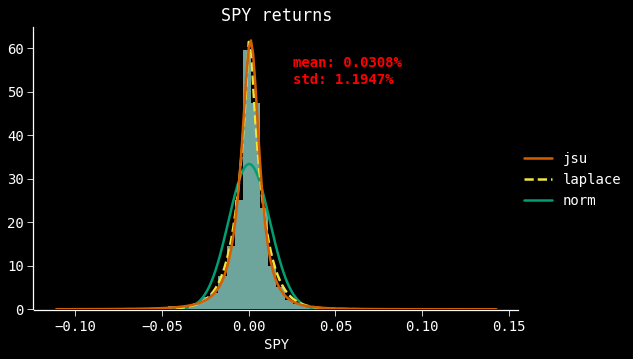

In [9]:
sym = 'SPY' # example symbol
df = rdf.loc['2005':].copy() # use 2005 cutoff b/c it's first full year of data

plot_dist(df, sym)

- `briefly introduce the chosen method for model evaluation and touch on the logic for why (AIC, BIC, DWAIC)`
- `start with sklearn demo using gaussian mixture with 1 component as example of fitting 1 normal distribution to the dataset, plot the densities`
- `then move to 2, 3, 4, N components`
- `discuss that in the limit, every data point can be fit with Gaussian with what effects on the mean and variance? but will certainly be overfit`
- `after provide bonus or appendix that describes the underlying expectation maximization algorithm`

preprocess data

In [10]:
s = df[sym].copy()
X = s.reshape(-1,1)
s[:5], X[:5]

(Date
 2005-01-03   -0.0047
 2005-01-04   -0.0123
 2005-01-05   -0.0069
 2005-01-06    0.0051
 2005-01-07   -0.0014
 Name: SPY, dtype: float64, array([[-0.00472662],
        [-0.01229483],
        [-0.00692446],
        [ 0.00507168],
        [-0.00143446]]))

In [13]:
def make_gmm(n_components, max_iter, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, max_iter=max_iter,
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

RANDOM_STATE = 777
k = 1
max_iter = 150 

gmm1 = make_gmm(k, max_iter)

In [14]:
gmm1.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=150,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=777, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [15]:
preds = gmm1.predict(X)

In [16]:
gmm1.means_, gmm1.covariances_

(array([[ 0.00030842]]), array([[[ 0.00014369]]]))

In [17]:
gmm1.bic(X)

-19292.246386802919

In [18]:
gmm2 = make_gmm(2, max_iter)
gmm2.fit(X)
gmm2.predict(X)
gmm2.means_, gmm2.covariances_, gmm2.bic(X)

(array([[-0.00263246],
        [ 0.00089767]]), array([[[  6.14422437e-04]],
 
        [[  4.72895216e-05]]]), -20438.972104693737)

In [19]:
gmm10 = make_gmm(10, max_iter)
gmm10.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=150,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=777, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [20]:
gmm10.means_, gmm10.covariances_, gmm10.bic(X)

(array([[ 0.00174487],
        [-0.02127485],
        [ 0.03218533],
        [-0.07698017],
        [-0.00239338],
        [ 0.01576889],
        [ 0.12303798],
        [-0.04190984],
        [ 0.00767909],
        [-0.01028666]]), array([[[  8.60805439e-06]],
 
        [[  3.37830536e-05]],
 
        [[  1.60395923e-04]],
 
        [[  2.36984238e-04]],
 
        [[  1.01469164e-05]],
 
        [[  2.24100205e-05]],
 
        [[  1.58469532e-04]],
 
        [[  6.75960043e-05]],
 
        [[  1.22318000e-05]],
 
        [[  1.49550740e-05]]]), -20410.842140456374)

In [21]:
def make_ic_series(list_of_tups, name=None):
    """fn: convert list of tuples for 
            information criterion (aic, bic) into series
    # args
        list_of_tups : list() of tuples()
            tuple[0] is n_component, tuple[1] is IC
        name : str(), name of IC
    
    # returns
        s : pd.Series()
            index is n_components, values are IC's
    """
    s = (pd.DataFrame(list_of_tups)
          .rename(columns={0:'n_components', 1:name})
          .set_index('n_components')
          .squeeze())
    return s

In [ ]:
# iterate over each symbol outputting the bic aic plot below, maybe gridspec it?

CPU times: user 1.92 s, sys: 7.76 s, total: 9.69 s
Wall time: 837 ms


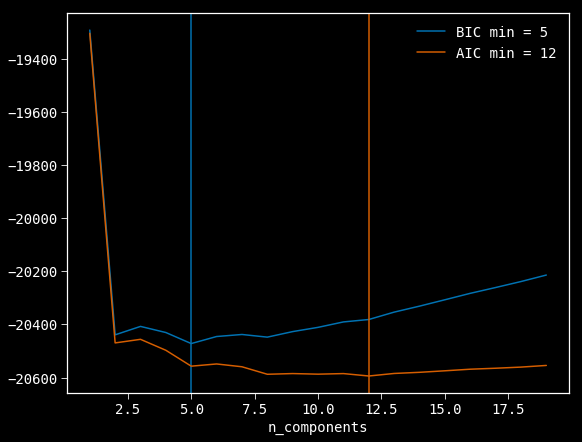

In [22]:
%%time 

n_components = np.arange(1,20)
aics = []
bics = []

for n in n_components:
    tmp_gmm = make_gmm(n, max_iter).fit(X)
    aics.append((n, tmp_gmm.aic(X)))
    bics.append((n, tmp_gmm.bic(X)))

bics = make_ic_series(bics, 'bic')
aics = make_ic_series(aics, 'aic')
    
plt.plot(n_components, bics.values, color=blue, label=f'BIC min = {np.argmin(bics)}')
plt.axvline(np.argmin(bics), color=blue)

plt.plot(n_components, aics.values, color=red, label=f'AIC min = {np.argmin(aics)}')
plt.axvline(np.argmin(aics), color=red)

plt.legend(loc='best')
plt.xlabel('n_components');

In [23]:
from matplotlib.dates import YearLocator, MonthLocator
from sklearn.model_selection import TimeSeriesSplit

# maybe gridspec plots below??

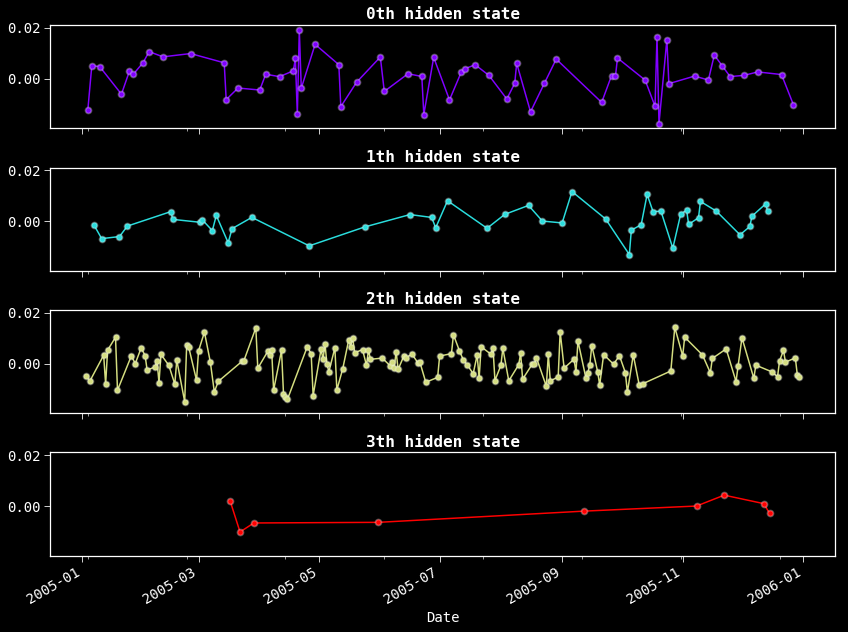

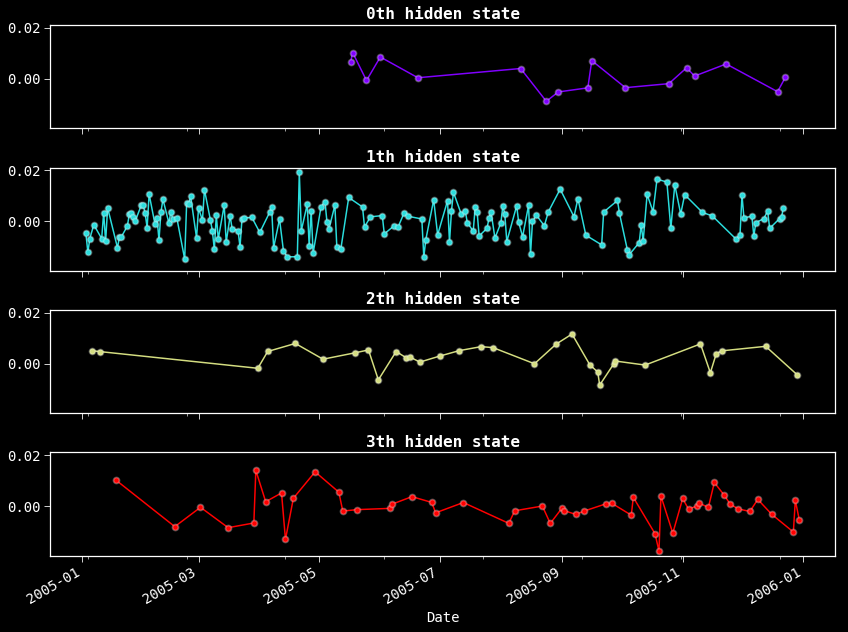

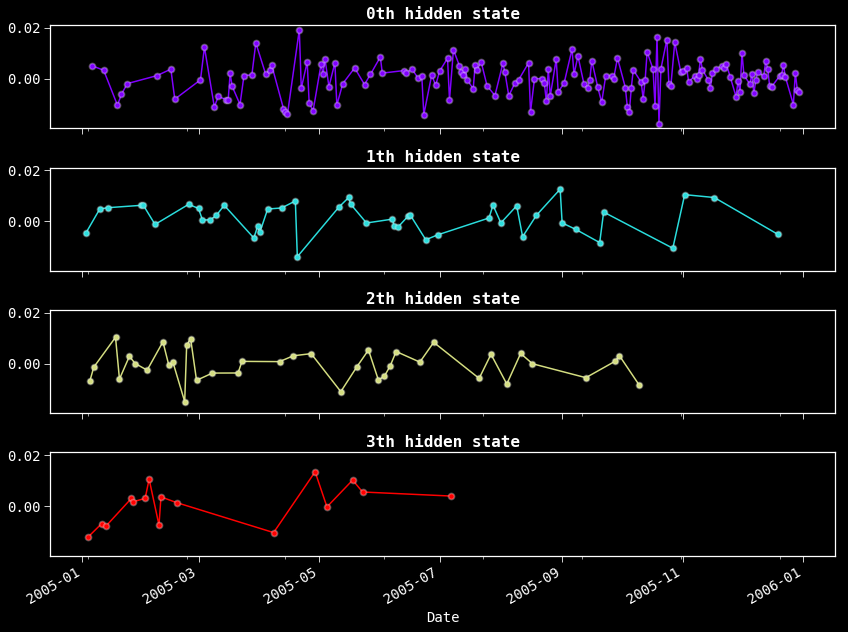

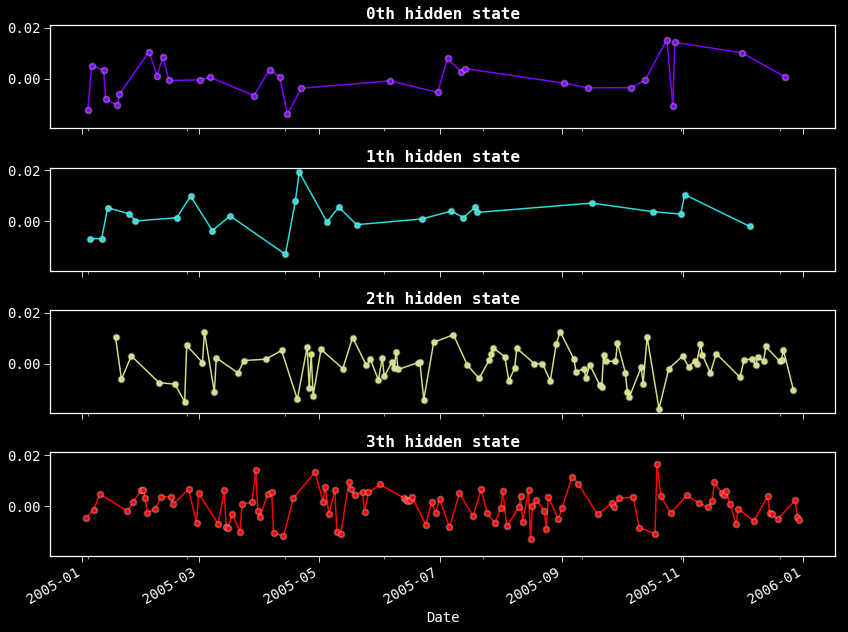

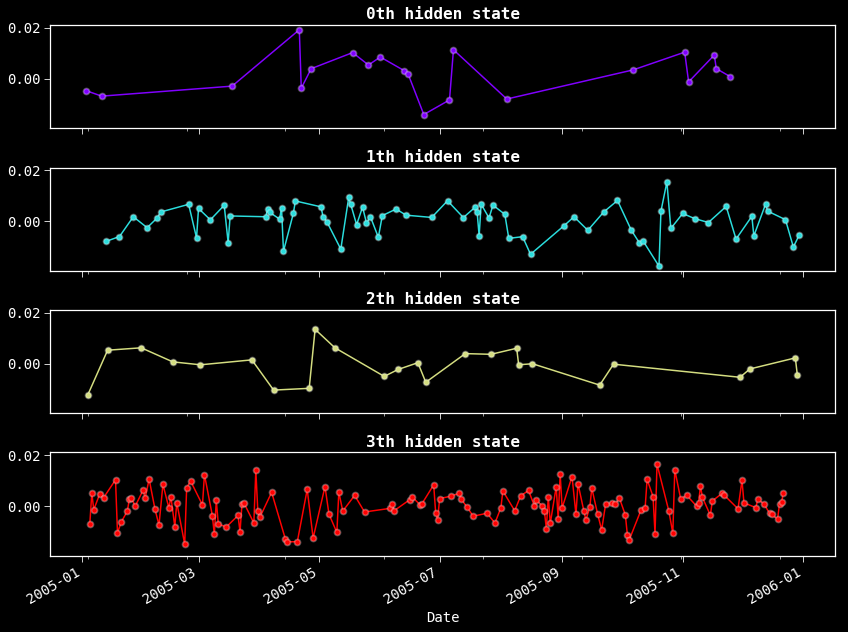

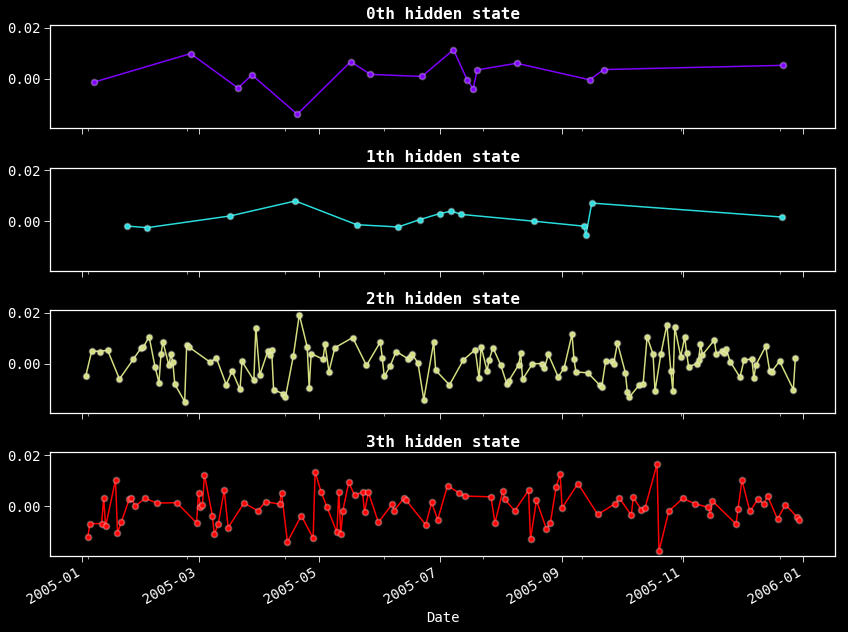

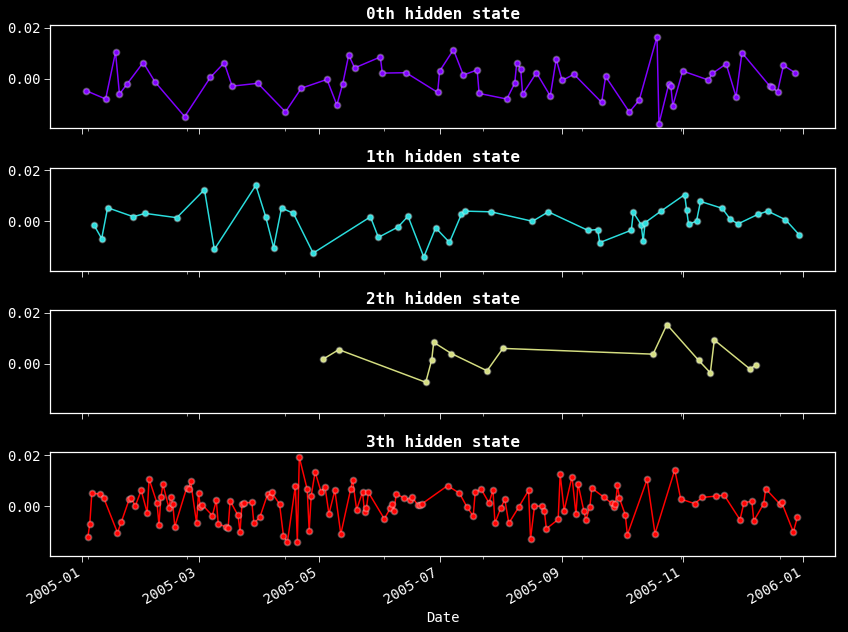

In [24]:


#xx = df[ex].copy() # pd series representing example data

_base = 252 # 1 trading year
_max_train_sizes = [_base*1, _base*2, _base*3, _base*5] # historical lookbacks
#_splits = np.arange(2, 12, 2)
_n_split=5 # try with different values

gs = gridspec.GridSpec(_n_split, len(_max_train_sizes), wspace=0.0)

fig = plt.figure(figsize=(20,25))

preds = []
pred_means = []
pred_covs = []

rows = []
#for j, max_size in enumerate(_max_train_sizes):
tscv = TimeSeriesSplit(n_splits=7, max_train_size=_base)

for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = X[train] # temporary train data
    tmp_test = X[test] # temporary test data

    gmm = make_gmm(4, max_iter)
    gmm.fit(tmp_train)
    
    hidden_states = gmm.predict(tmp_train)
    
    preds.append(hidden_states)
    pred_means.append(gmm.means_)
    pred_covs.append(gmm.covariances_)
    
    fig, axs = plt.subplots(gmm.n_components, sharex=True, sharey=True, figsize=(12,9))
    colors = plt.cm.rainbow(np.linspace(0, 1, gmm.n_components))

    for i, (ax, color) in enumerate(zip(axs, colors)):
        
        hs = pd.Series(hidden_states.copy())
        mask = hs[hs==i] # index locs of each state
        
        marker_edge_color = mpl.colors.colorConverter.to_rgba('white', alpha=.3)
        s[mask.index].plot(ax=ax, c=color, 
                           marker='o', markersize=6, 
                           markeredgecolor=marker_edge_color,
                           markeredgewidth=1.75)

        ax.set_title(f"{i}th hidden state", fontsize=16, fontweight='demi')

    plt.tight_layout()    

In [46]:
#(s.iloc[train].to_frame().assign(hidden_states=hidden_states).assign(mkt_cret=lambda df: df[sym].cumsum()).reset_index())

def make_state_df(hidden_states, s):
    states = (pd.DataFrame(hidden_states, columns=['states'], index=tmp_s.index)
              .join(s, how='inner')
              .assign(mkt_cret=tmp_s.cumsum())
              .reset_index(drop=False))
    return states
    
def plot_cuml_state(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date',y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

def plot_facet_cuml_states(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date',y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')         
         #+ pn.stat_smooth(method='loess')
         + pn.facet_wrap(f'~{state_col}')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

def plot_facet_states(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date', y=sym, color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.stat_smooth(method='lowess')
         + pn.facet_wrap(f'~{state_col}')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g


*****************************************************************************


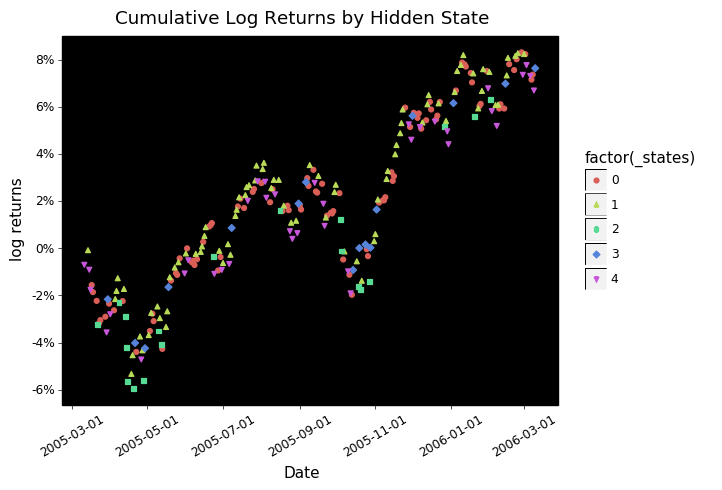

<ggplot: (-9223363300988079840)>


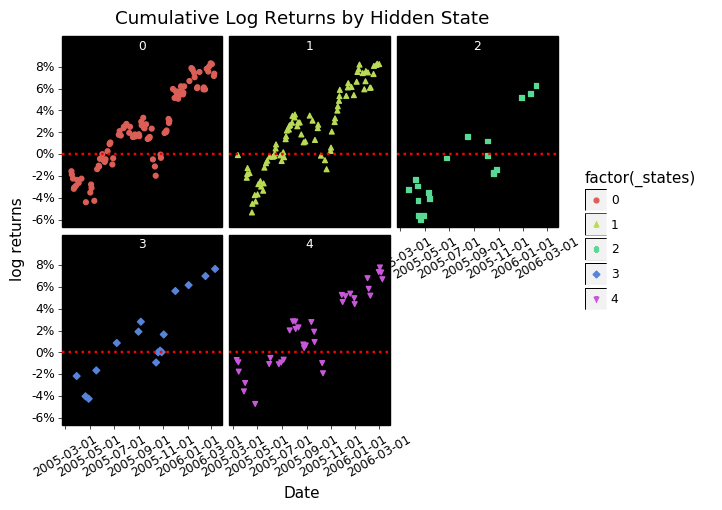

<ggplot: (8735816599935)>


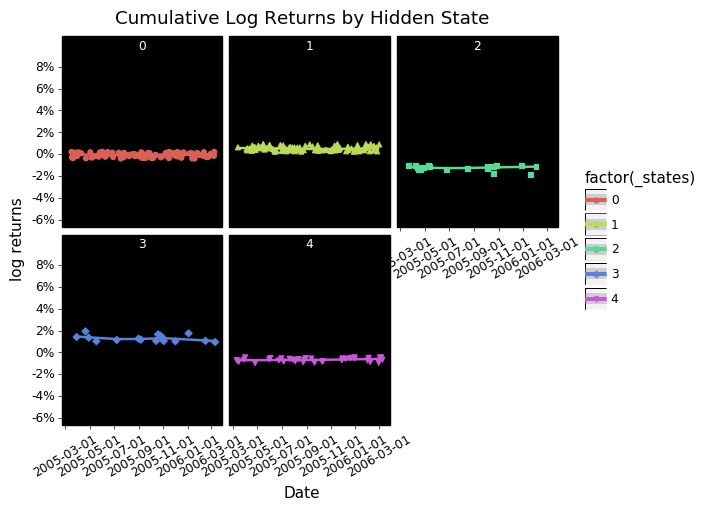

<ggplot: (-9223363301038125038)>


_states,0,1,2,3,4
count,97.0000,83.0000,19.0000,16.0000,37.0000
mean,-0.0007,0.0051,-0.0126,0.0130,-0.0068
std,0.0018,0.0020,0.0024,0.0030,0.0016
min,-0.0040,0.0022,-0.0184,0.0095,-0.0098
25%,-0.0020,0.0035,-0.0136,0.0105,-0.0083
50%,-0.0006,0.0047,-0.0119,0.0121,-0.0067
75%,0.0010,0.0066,-0.0108,0.0146,-0.0054
max,0.0022,0.0093,-0.0102,0.0192,-0.0045



*****************************************************************************


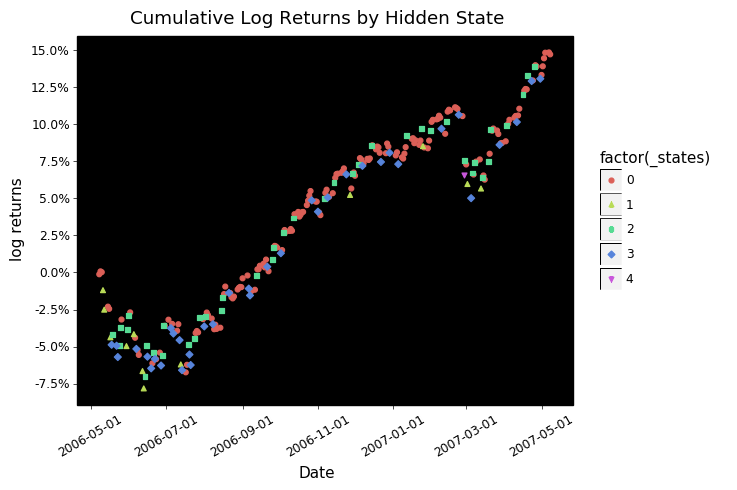

<ggplot: (-9223363300988258921)>


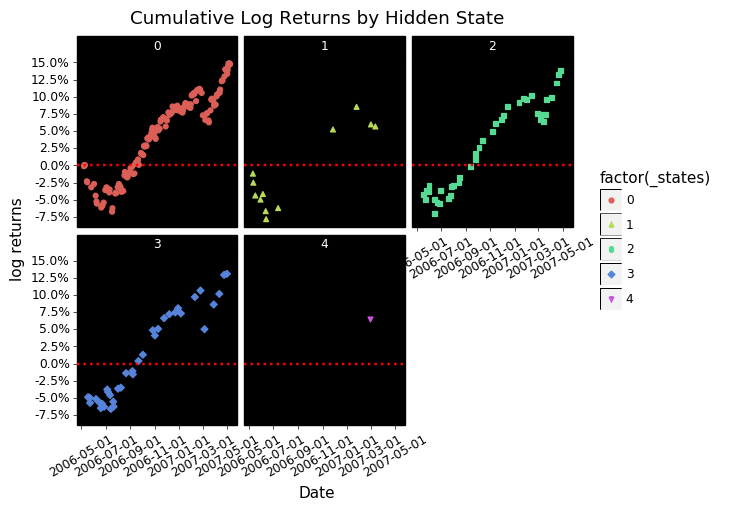

<ggplot: (-9223363300987687164)>


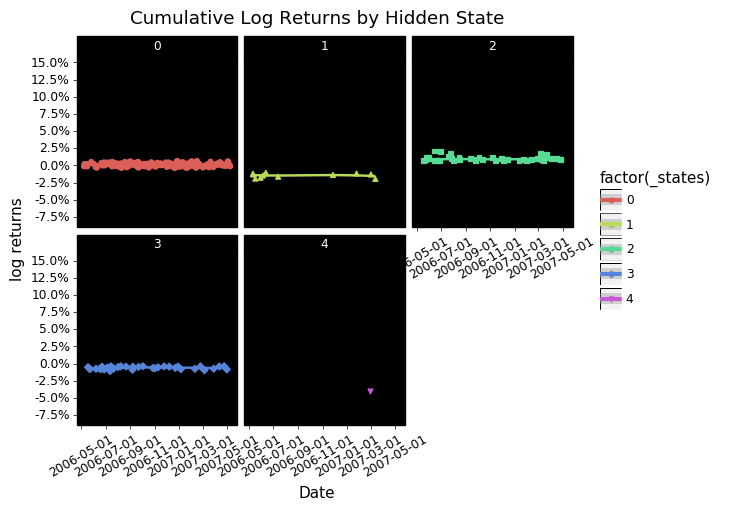

<ggplot: (8735866676207)>


_states,0,1,2,3,4
count,163.0000,12.0000,40.0000,36.0000,1.0000
mean,0.0011,-0.0145,0.0103,-0.0062,-0.0398
std,0.0025,0.0030,0.0036,0.0019,nan
min,-0.0037,-0.0196,0.0067,-0.0107,-0.0398
25%,-0.0008,-0.0168,0.0077,-0.0075,-0.0398
50%,0.0011,-0.0135,0.0093,-0.0062,-0.0398
75%,0.0027,-0.0121,0.0113,-0.0044,-0.0398
max,0.0065,-0.0109,0.0210,-0.0037,-0.0398



*****************************************************************************


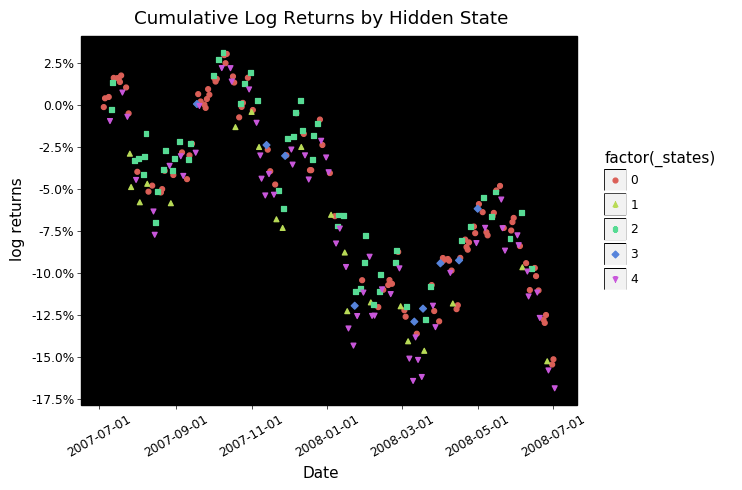

<ggplot: (8735867275177)>


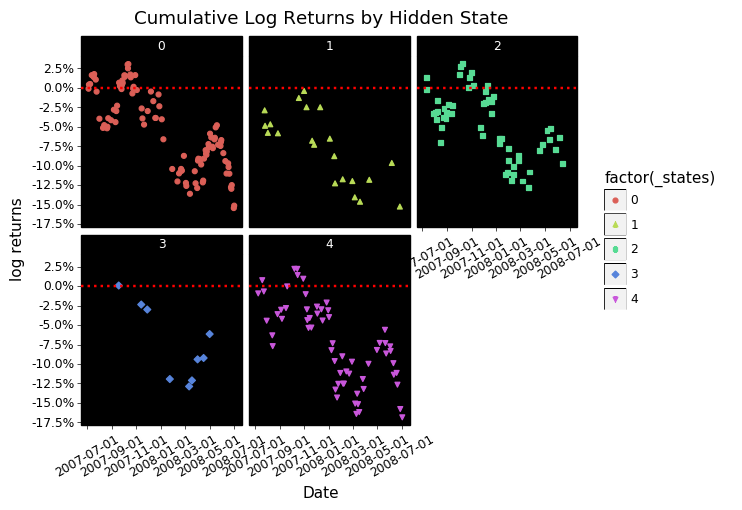

<ggplot: (-9223363300988846746)>


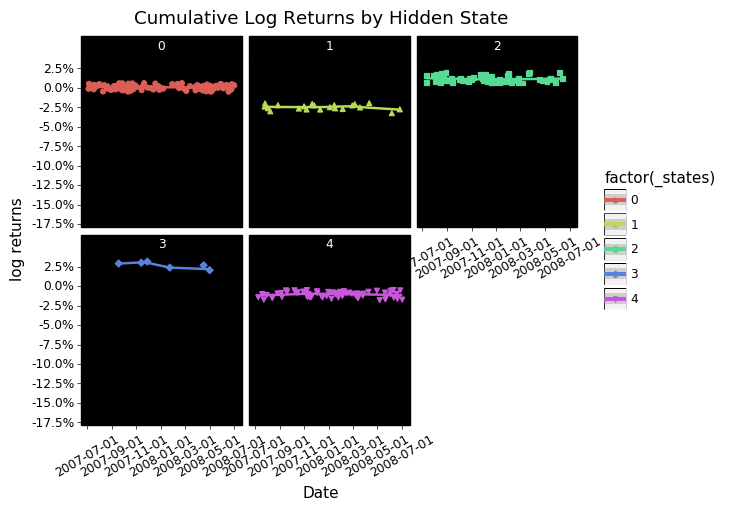

<ggplot: (8735866036393)>


_states,0,1,2,3,4
count,104.0000,21.0000,56.0000,9.0000,62.0000
mean,0.0008,-0.0247,0.0116,0.0302,-0.0106
std,0.0029,0.0034,0.0039,0.0062,0.0036
min,-0.0049,-0.0324,0.0063,0.0205,-0.0180
25%,-0.0016,-0.0271,0.0083,0.0267,-0.0139
50%,0.0007,-0.0248,0.0109,0.0300,-0.0099
75%,0.0030,-0.0223,0.0142,0.0346,-0.0080
max,0.0061,-0.0196,0.0198,0.0407,-0.0050



*****************************************************************************


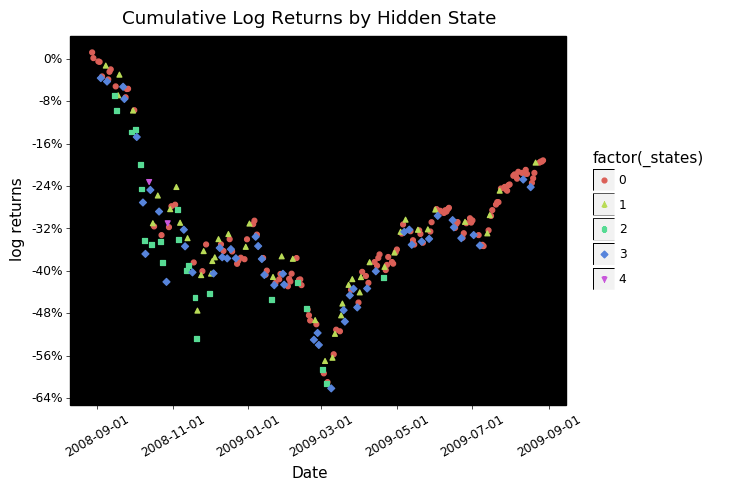

<ggplot: (-9223363301038306812)>


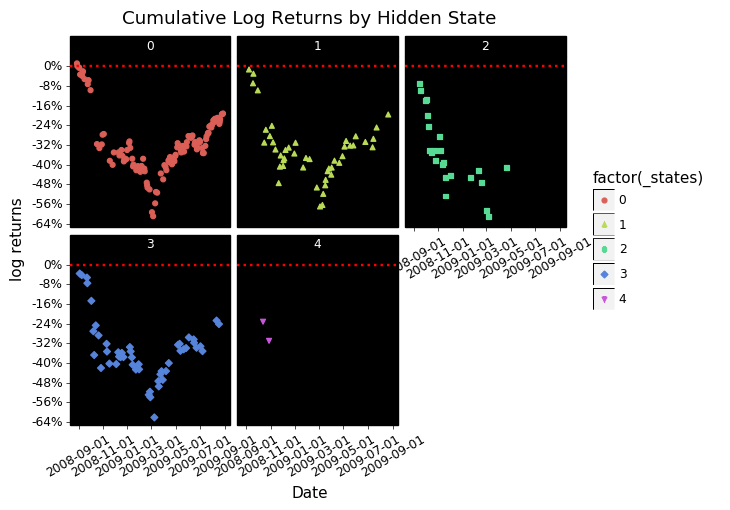

<ggplot: (-9223363301038507306)>


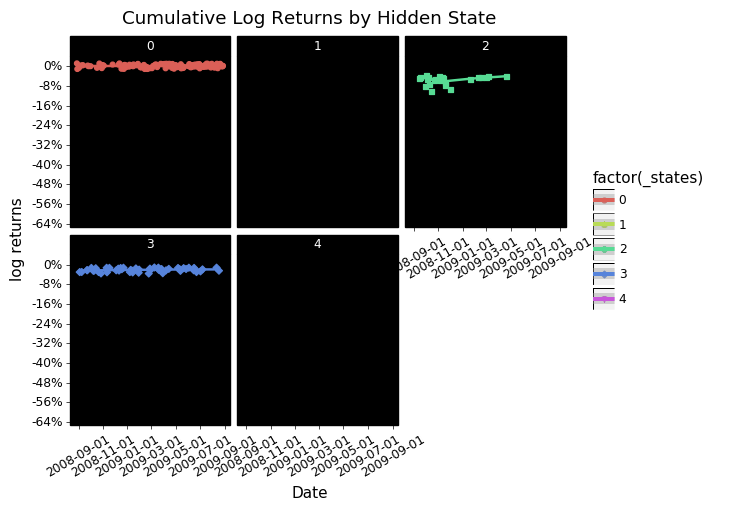

<ggplot: (-9223363301038529220)>


_states,0,1,2,3,4
count,131.0000,46.0000,23.0000,50.0000,2.0000
mean,0.0031,0.0337,-0.0567,-0.0218,0.1230
std,0.0073,0.0129,0.0175,0.0071,0.0177
min,-0.0108,0.0192,-0.1036,-0.0364,0.1105
25%,-0.0024,0.0235,-0.0616,-0.0255,0.1168
50%,0.0029,0.0302,-0.0512,-0.0216,0.1230
75%,0.0087,0.0389,-0.0454,-0.0151,0.1293
max,0.0187,0.0694,-0.0369,-0.0118,0.1356



*****************************************************************************


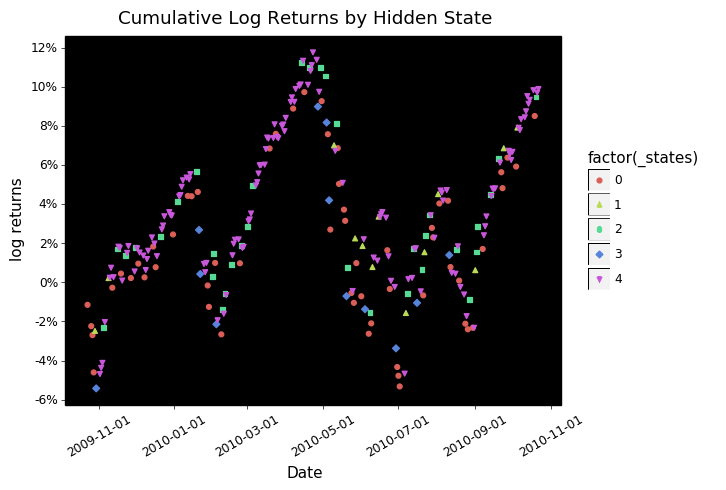

<ggplot: (8735866800546)>


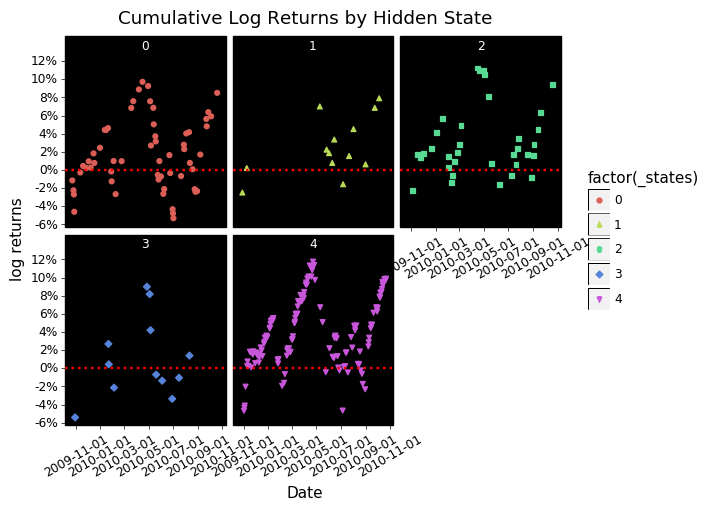

<ggplot: (-9223363300999962645)>


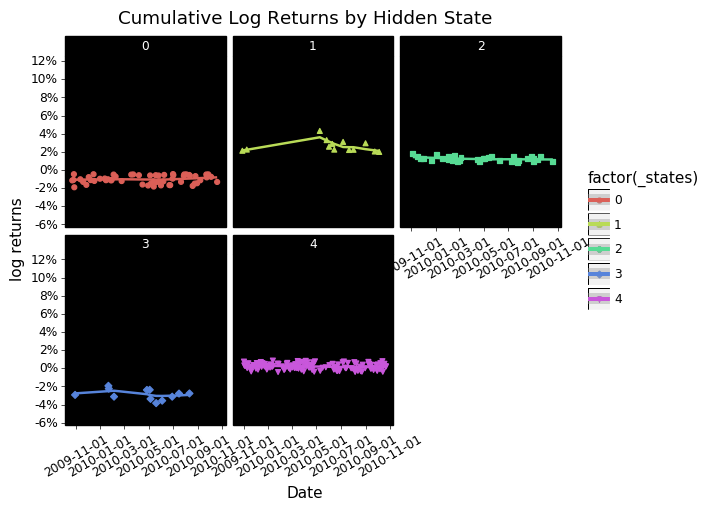

<ggplot: (-9223363300999913163)>


_states,0,1,2,3,4
count,58.0000,13.0000,34.0000,12.0000,135.0000
mean,-0.0102,0.0263,0.0124,-0.0288,0.0020
std,0.0044,0.0066,0.0024,0.0057,0.0032
min,-0.0191,0.0199,0.0086,-0.0385,-0.0042
25%,-0.0131,0.0221,0.0104,-0.0320,-0.0003
50%,-0.0106,0.0225,0.0123,-0.0287,0.0020
75%,-0.0058,0.0295,0.0143,-0.0239,0.0047
max,-0.0045,0.0431,0.0182,-0.0194,0.0084



*****************************************************************************


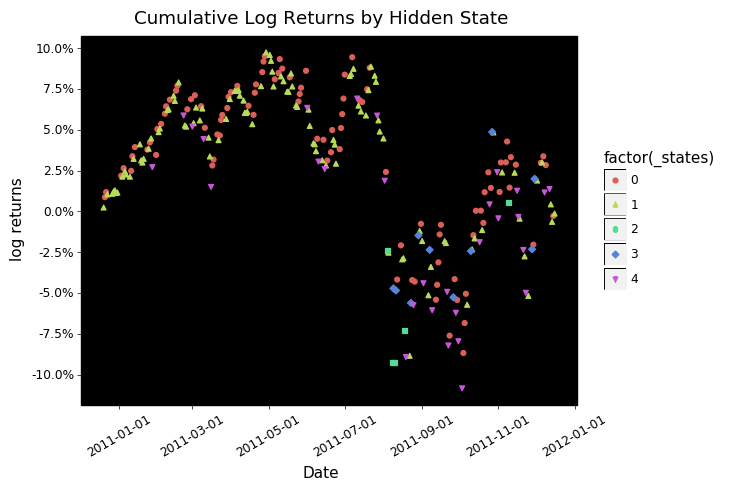

<ggplot: (-9223363301038704885)>


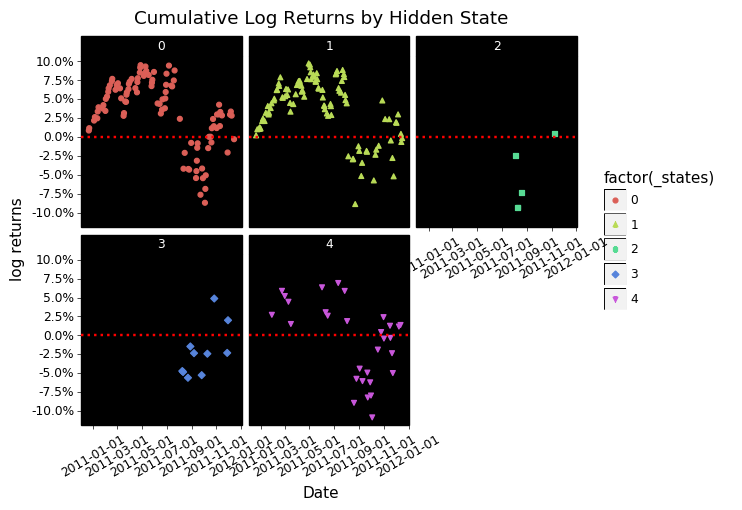

<ggplot: (-9223363301038738635)>


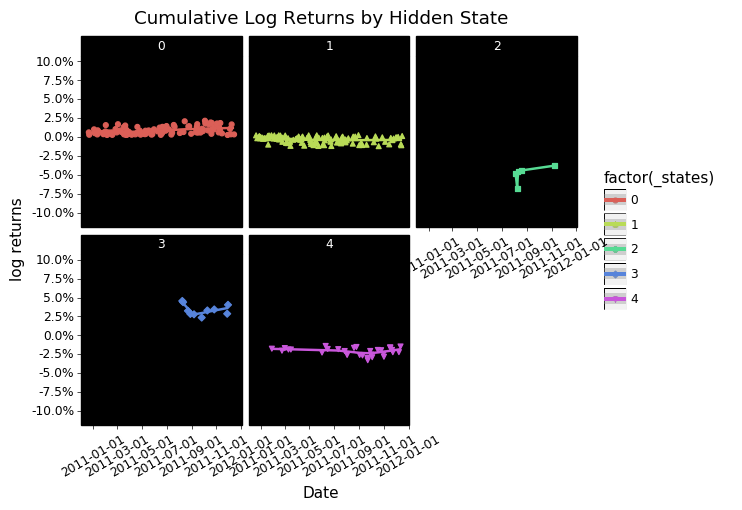

<ggplot: (8735816010984)>


_states,0,1,2,3,4
count,99.0000,108.0000,5.0000,10.0000,30.0000
mean,0.0089,-0.0032,-0.0484,0.0337,-0.0212
std,0.0051,0.0042,0.0112,0.0073,0.0049
min,0.0028,-0.0119,-0.0673,0.0235,-0.0329
25%,0.0047,-0.0068,-0.0480,0.0284,-0.0251
50%,0.0075,-0.0019,-0.0452,0.0326,-0.0200
75%,0.0129,0.0003,-0.0441,0.0388,-0.0177
max,0.0217,0.0026,-0.0376,0.0455,-0.0140



*****************************************************************************


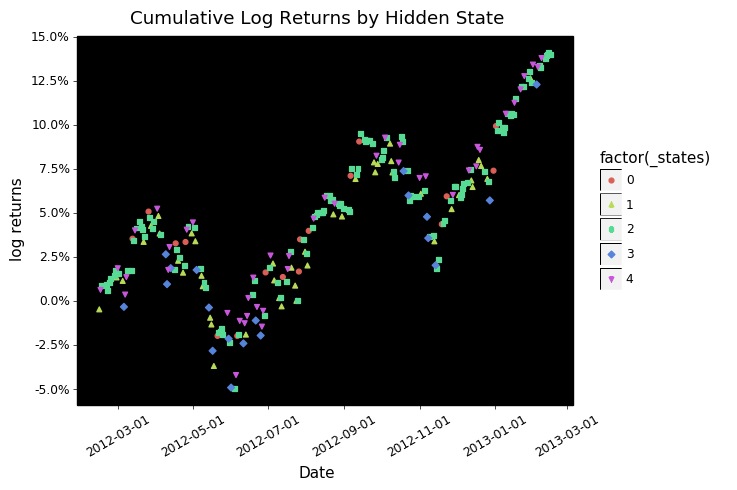

<ggplot: (-9223363300988457349)>


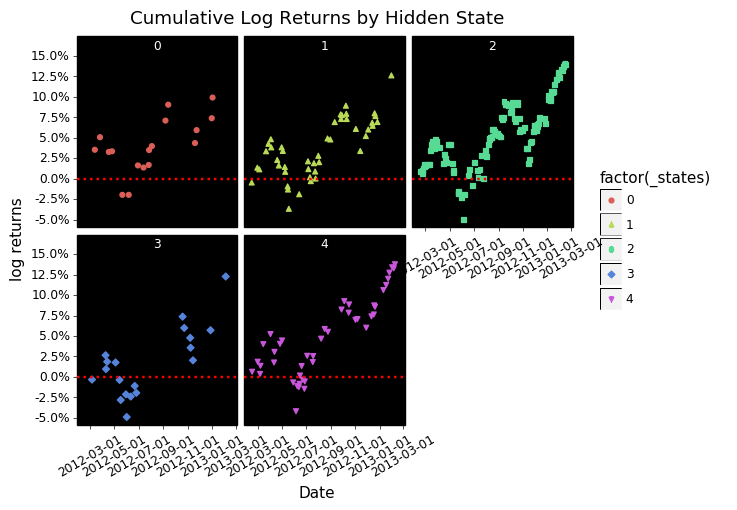

<ggplot: (8735866963902)>


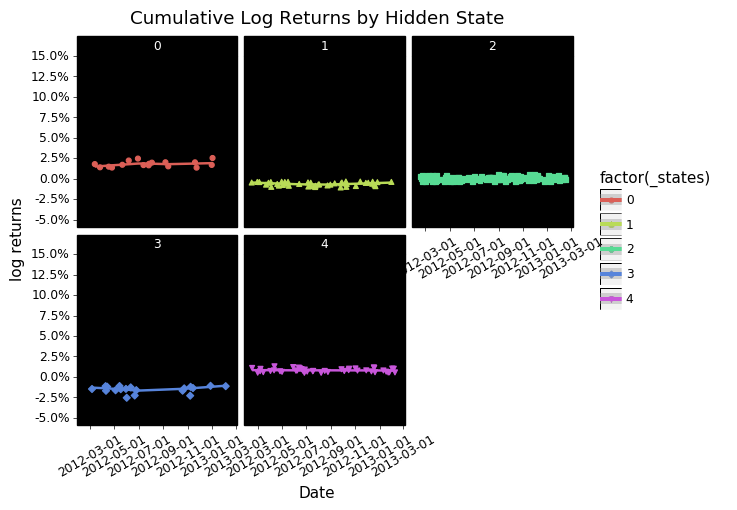

<ggplot: (-9223363300921549529)>


_states,0,1,2,3,4
count,17.0000,45.0000,127.0000,19.0000,44.0000
mean,0.0180,-0.0064,0.0004,-0.0153,0.0081
std,0.0036,0.0022,0.0022,0.0043,0.0021
min,0.0135,-0.0107,-0.0034,-0.0255,0.0050
25%,0.0151,-0.0084,-0.0012,-0.0165,0.0065
50%,0.0170,-0.0062,0.0004,-0.0146,0.0077
75%,0.0200,-0.0045,0.0019,-0.0120,0.0101
max,0.0253,-0.0034,0.0049,-0.0109,0.0130



*****************************************************************************


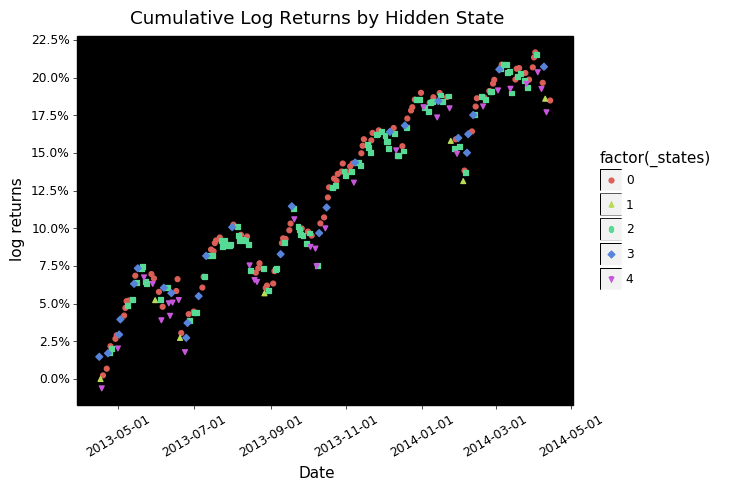

<ggplot: (8735816349567)>


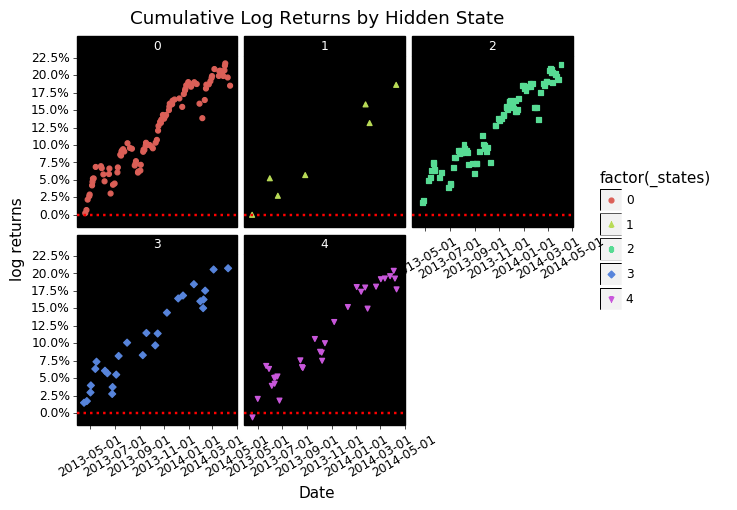

<ggplot: (8735815827576)>


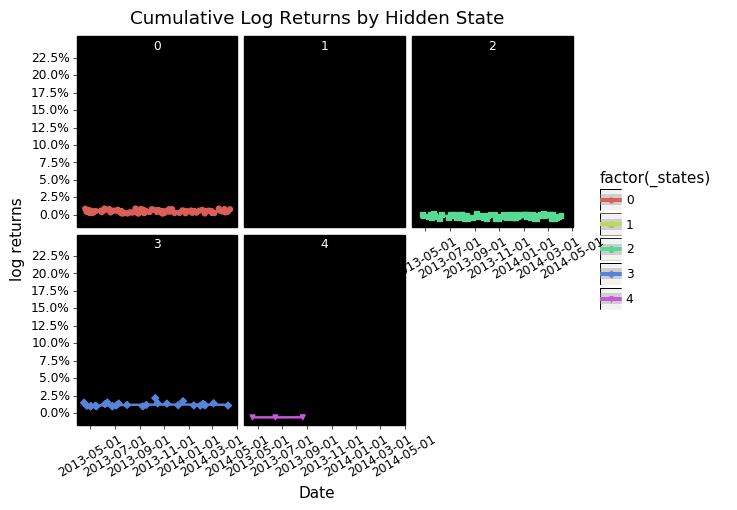

<ggplot: (8735815837574)>


_states,0,1,2,3,4
count,94.0000,7.0000,93.0000,27.0000,31.0000
mean,0.0049,-0.0194,-0.0019,0.0121,-0.0095
std,0.0020,0.0042,0.0020,0.0027,0.0026
min,0.0016,-0.0251,-0.0059,0.0092,-0.0141
25%,0.0033,-0.0222,-0.0035,0.0103,-0.0115
50%,0.0050,-0.0212,-0.0018,0.0111,-0.0090
75%,0.0061,-0.0155,0.0000,0.0135,-0.0071
max,0.0091,-0.0145,0.0014,0.0213,-0.0062



*****************************************************************************


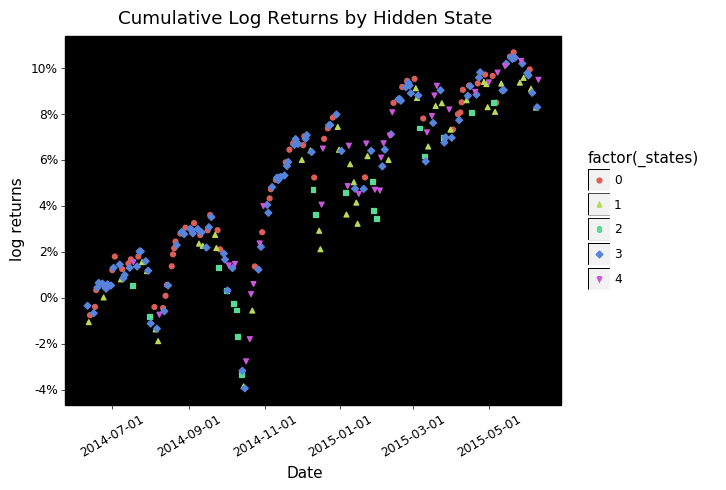

<ggplot: (8735854706580)>


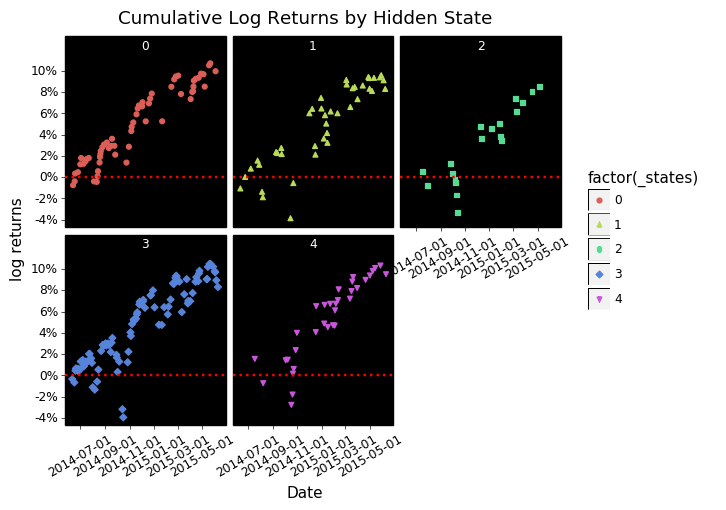

<ggplot: (-9223363300988597125)>


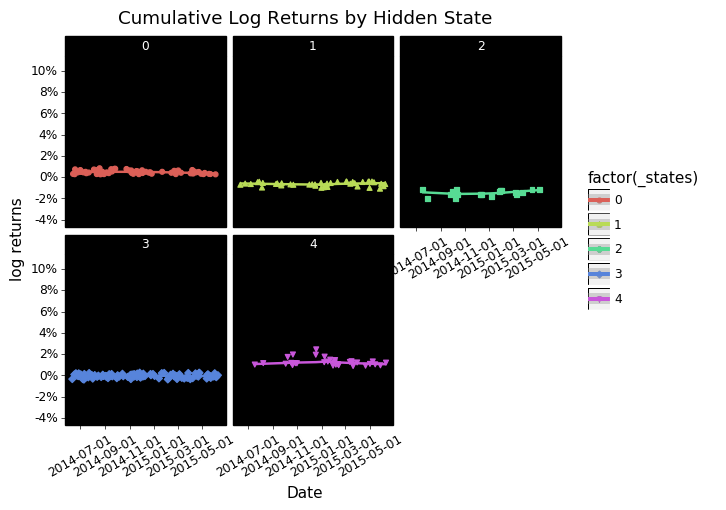

<ggplot: (8735867185591)>


_states,0,1,2,3,4
count,59.0000,42.0000,19.0000,99.0000,33.0000
mean,0.0048,-0.0066,-0.0149,-0.0004,0.0126
std,0.0016,0.0019,0.0027,0.0017,0.0035
min,0.0026,-0.0108,-0.0200,-0.0040,0.0088
25%,0.0033,-0.0078,-0.0163,-0.0016,0.0104
50%,0.0045,-0.0063,-0.0148,-0.0005,0.0117
75%,0.0059,-0.0049,-0.0128,0.0010,0.0131
max,0.0083,-0.0041,-0.0114,0.0026,0.0244



*****************************************************************************


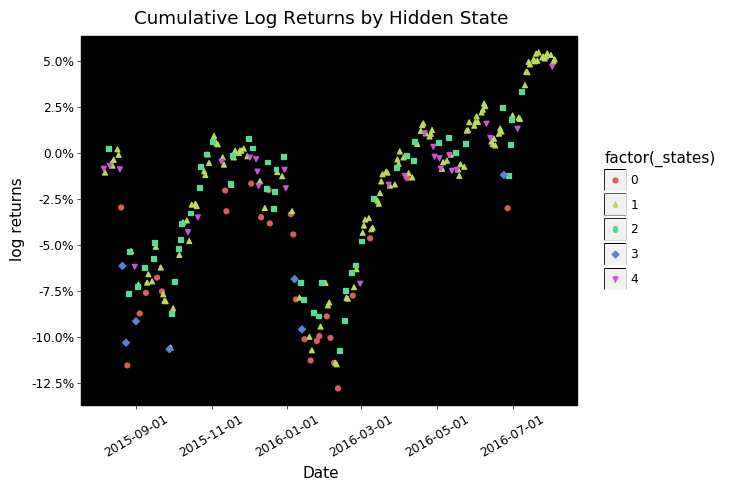

<ggplot: (8735854879920)>


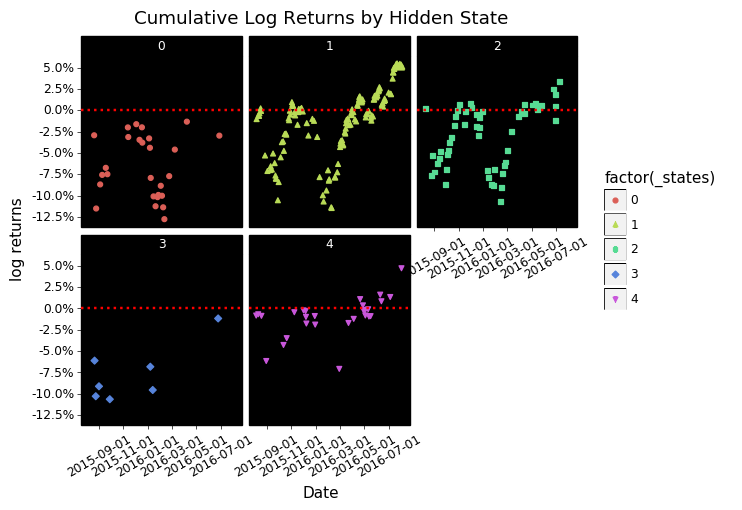

<ggplot: (8735854943664)>


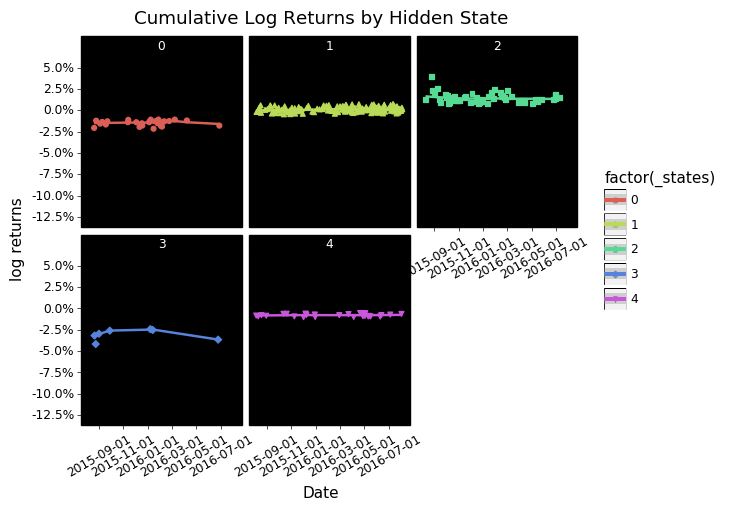

<ggplot: (-9223363300991951921)>


_states,0,1,2,3,4
count,27.0000,138.0000,52.0000,7.0000,28.0000
mean,-0.0149,0.0009,0.0146,-0.0308,-0.0079
std,0.0031,0.0030,0.0056,0.0065,0.0015
min,-0.0217,-0.0048,0.0079,-0.0417,-0.0103
25%,-0.0174,-0.0013,0.0106,-0.0342,-0.0094
50%,-0.0141,0.0007,0.0136,-0.0296,-0.0079
75%,-0.0127,0.0032,0.0168,-0.0257,-0.0066
max,-0.0109,0.0072,0.0390,-0.0243,-0.0054


In [303]:
for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = s.iloc[train].reshape(-1,1) # temporary train data
    tmp_test = s.iloc[test].reshape(-1,1) # temporary test data

    gmm = make_gmm(5, max_iter)
    gmm.fit(tmp_train)
    
    hidden_states = gmm.predict(tmp_train)
    
    state_df = (s.iloc[train].to_frame()
                .assign(_states=hidden_states)
                .assign(mkt_cret=lambda df: df[sym].cumsum())
                .reset_index())
    
    preds.append(hidden_states)
    pred_means.append(gmm.means_)
    pred_covs.append(gmm.covariances_)
    
    scol = '_states'
    g = plot_cuml_state(state_df, state_col=scol)
    g1 = plot_facet_cuml_states(state_df, state_col=scol)
    g2 = plot_facet_states(state_df, state_col=scol)
    print()
    print('*'*77)
    print(g);
    print(g1);
    print(g2)
    display(state_df.groupby(scol)[sym].describe().T)
    #break

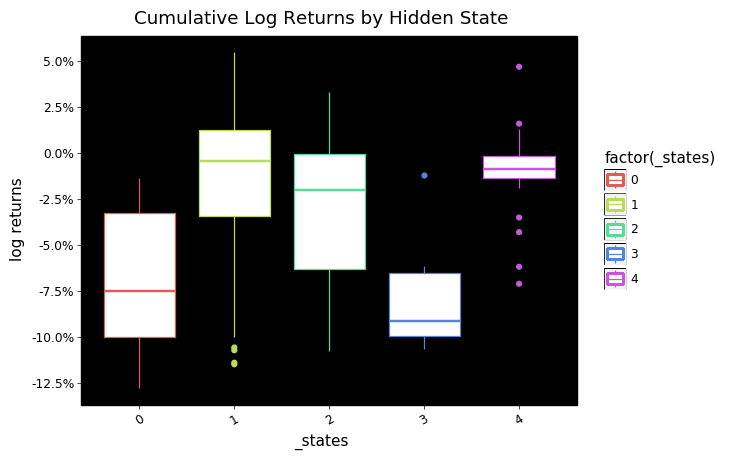

<ggplot: (-9223363300915774425)>

In [398]:
def boxplot_states(states, state_col):
    g = (pn.ggplot(states, pn.aes(x=state_col,y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_boxplot()#pn.aes(shape=f'factor({state_col})'))
         #+ pn.stat_smooth(method='loess')
         #+ pn.facet_wrap(f'~{state_col}')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

boxplot_states(state_df, scol)

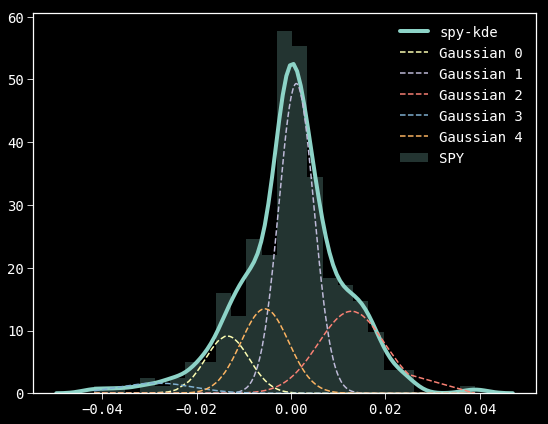

In [392]:
# reshape observed returns
x = state_df[sym].sort_values().reshape(-1,1)

# agg pdfs into list
agg_pdfs = [w * stats.norm.pdf(x, mu, sd) 
            for mu, sd, w in zip(gmm.means_, np.sqrt(gmm.covariances_), gmm.weights_)]
# sum density in case
summed_density = np.sum(np.array(pdfs), axis=0)

# plot observed data distribution #and a single component gaussian fit aka norm fit
sns.distplot(x, hist=True, hist_kws=dict(alpha=0.25),
             kde=True, kde_kws=dict(lw=4, label='spy-kde'),
             #fit=stats.norm, fit_kws=dict(lw=2, label='spy-norm-fit', color='pink'),
             label=sym)

# plot component gaussians
for i in range(len(pdfs)): plt.plot(x, pdfs[i], ls='--', label=f'Gaussian {i}');  

plt.legend()

Note the difference between the SPY distribution fit with multiple Gaussians vs below with a single Gaussian fit.

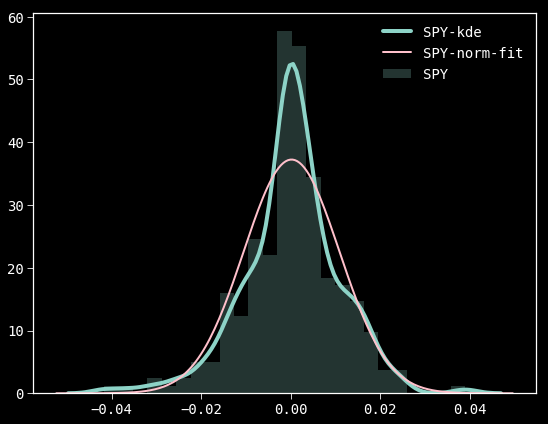

In [397]:
sns.distplot(x, hist=True, hist_kws=dict(alpha=0.25, label=f'{sym}-hist'),
             kde=True, kde_kws=dict(lw=4, label=f'{sym}-kde'),
             fit=stats.norm, fit_kws=dict(lw=2, color='pink', label=f'{sym}-norm-fit'),
             label=sym)
plt.legend()

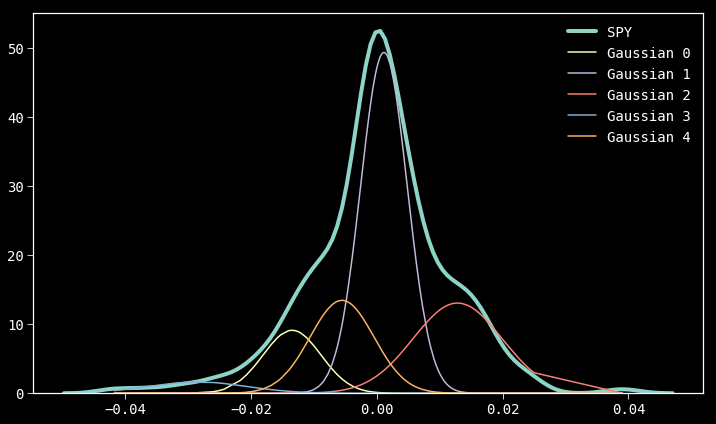

In [317]:
x = state_df[sym].sort_values().reshape(-1,1)

weights = gmm.weights_
means = gmm.means_
covars = gmm.covariances_

agg_pdf = [weights[i]*stats.norm.pdf(x,means[i],np.sqrt(covars[i])) for i in range(len(weights))]

fig, ax = plt.subplots(figsize=(12,7))

sns.kdeplot(state_df[sym], ax=ax, linewidth=4)
for i, _ in enumerate(range(len(weights))):
    ax.plot(x,weights[i]*stats.norm.pdf(x,means[i],np.sqrt(covars[i])), label=f'Gaussian {i}')

ax.legend()

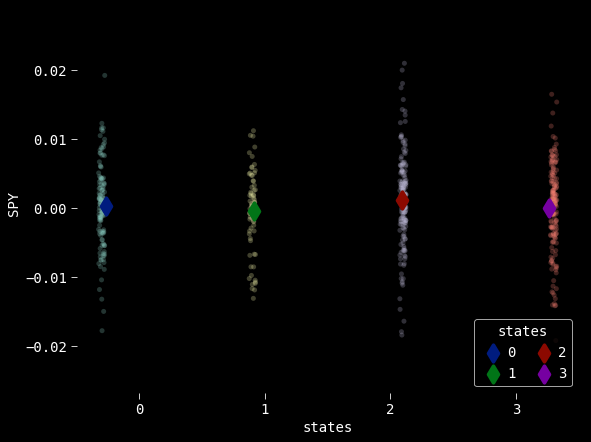

In [190]:
sym = 'SPY'
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="states", y=sym, hue="states", data=states,
              dodge=True, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x="states", y=sym, hue="states", data=states,
              dodge=.532, join=False, palette="dark",
              markers="d", markersize=6, scale=1.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title="states",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=2, frameon=True)

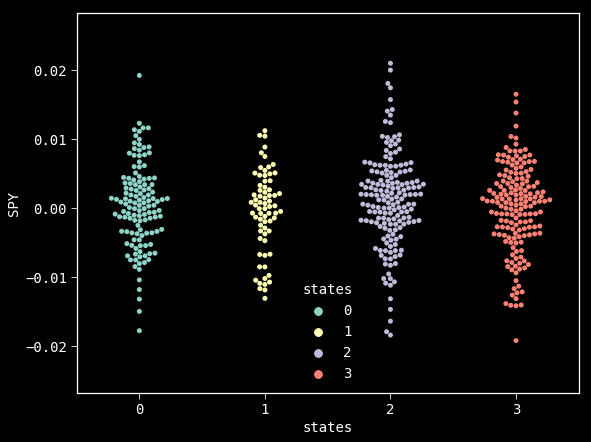

In [186]:
# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="states", y="SPY", hue="states", data=states)